In [18]:
import pandas as pd
import numpy as np
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from math import sqrt

def prepare_data(window_size, lags):
    # Load your time series dataset
    data = pd.read_csv("C:/Users/raulp/OneDrive/Documenten/KU Leuven/Master HIRB/Thesis/sens_RUL_generated_just.csv")

    # Columns to convert to numeric
    numeric_columns = ["RMSVibration.mean", "Temperature.mean", "SpeedPeak.mean", "Kurtosis.mean",
                       "RMSAcceleration.mean", "Skewness.mean", "MaximumAbsoluteVibration.mean"]

    # Use "." as decimal separator instead of ","
    for col in numeric_columns:
        data[col] = data[col].str.replace(',', '.')

    # Convert selected columns to numeric
    # Parameter errors="coerce" converts problematic values into NaN
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")
    
    # Feature Engineering
    data['Timestamp'] = pd.to_datetime(data['ReadableDate'], errors="raise")
    data['Date'] = data['Timestamp'].dt.date
    data = data.drop(['Unnamed: 0', 'Time', 'TrueRUL'], axis=1)

    # Aggregate data into 1 observation per day
    data = data.groupby('Date').agg(['median', 'std'])

    # Flatten the MultiIndex columns (without this, columns are grouped)
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    data = data.drop("FloatRUL_std", axis=1)

    cols = data.columns.difference(['FloatRUL_median'])
    
    # Feature 1: Lags and deltas of the attributes
    for i in range(1, lags+1):
        for col in cols:
            data[f'{col}_Lag{i}'] = data[col].shift(i)
            data[f'{col}_Lag{i}'][i - 1] = data[col][i - 1]
            data[f'{col}_Delta{i}'] = data[col] - data[f'{col}_Lag{i}']
    data = data.dropna()

    # Feature 2: Rolling statistics => Hyperparameter "window_size"
    for column in cols:
        data[f'{column}_RollingMean'] = data[column].rolling(window=window_size, min_periods=1).mean()
        data[f'{column}_RollingStd'] = data[column].rolling(window=window_size, min_periods=1).std()
        data[f'{column}_RollingMin'] = data[column].rolling(window=window_size, min_periods=1).min()
        data[f'{column}_RollingMax'] = data[column].rolling(window=window_size, min_periods=1).max()
        data[f'{column}_RollingStd'][0] = 0
    data = data.drop(['Kurtosis.mean_std_RollingMax'], axis=1)
    return data


In [19]:
def create_monthly_models(data, params=None):
    YM = []
    for date in data.index:
        YM.append(str(date.year) + str(date.month).zfill(2))
    data['YM'] = YM
    
    # Group by 'YM' and iterate over each group
    months = []
    monthly_models = []
    for month, month_data in data.groupby('YM'):
        #print(month_data)
        if len(month_data) >= 7:
            train_size = int(0.4 * len(month_data))
            val_size = int(0.3 * len(month_data))
            train_data, test_data = month_data[:train_size+val_size], month_data[train_size+val_size:]

            # Split the data into features (X) and target variable (y)
            X_train, y_train = train_data.drop(['FloatRUL_median', 'YM'], axis=1), train_data['FloatRUL_median']
            X_test, y_test = test_data.drop(['FloatRUL_median', 'YM'], axis=1), test_data['FloatRUL_median']
            
            if params == None:
                model = RandomForestRegressor(n_jobs=-1, n_estimators=120, min_samples_split=10, max_features='sqrt', random_state=42)
            else:
                model = RandomForestRegressor()
                model.set_params(**params)
            model.fit(X_train, y_train)
            monthly_models.append(model)
            months.append(month)
    
    return data, months, monthly_models

In [20]:
def create_windows(window_size, data, months, monthly_models):
    windows = []
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i+window_size]
        windows.append(window)
    
    for index, window in enumerate(windows):
        predictions = [None]
        for i in range(len(months)):
            if months[i] == window['YM'][0]:
                if i == 0:
                    predictions = monthly_models[i].predict(window.drop(['FloatRUL_median', 'YM'], axis=1))
                else:
                    predictions = monthly_models[i - 1].predict(window.drop(['FloatRUL_median', 'YM'], axis=1))
        if predictions[0] != None:
            for i, prediction in enumerate(predictions):
                column_name = f"Predictions_{i}"
                if column_name not in data.columns:
                    data[column_name] = 0.0  # Initialize the column with zeros if it doesn't exist
                data[column_name].iloc[index + i] = prediction
    data = data.drop('YM', axis=1)
    return data


In [21]:
import warnings

# Suppress SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

data = prepare_data(25, 6)
data, months, monthly_models = create_monthly_models(data)
data = create_windows(1, data, months, monthly_models)


In [13]:
# Split data into train, validation, and test sets: 70-15-15
train_size = int(0.70 * len(data))
val_size = int(0.15 * len(data))
train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

# Split the data into features (X) and target variable (y)
X_train, y_train = train_data.drop('FloatRUL_median', axis=1), train_data['FloatRUL_median']
X_val, y_val = val_data.drop('FloatRUL_median', axis=1), val_data['FloatRUL_median']
X_test, y_test = test_data.drop('FloatRUL_median', axis=1), test_data['FloatRUL_median']

model = RandomForestRegressor(n_estimators=160, min_samples_split=4, n_jobs=-1, max_features="sqrt", random_state=42)

model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = sqrt(val_mse)
print(f'Validation RMSE: {val_rmse}')

# Make predictions on the test set
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = sqrt(test_mse)
print(f'Test RMSE: {test_rmse}')


Validation RMSE: 22.43156124338852
Test RMSE: 23.504318748026293


In [6]:
feature_importances = model.feature_importances_
feature_names = X_train.columns

imp = []
for feature, importance in zip(feature_names, feature_importances):
    imp.append([feature, importance])

def keyFunc(mtx):
    return mtx[1]

imp.sort(reverse=True, key=keyFunc)
for elem in imp:
    print(elem)

['Kurtosis.mean_median_RollingStd', 0.08976315728556424]
['SpeedPeak.mean_std_RollingMean', 0.06183671318851097]
['SpeedPeak.mean_std_RollingMin', 0.051420897285565495]
['Kurtosis.mean_median_RollingMean', 0.05102585989312873]
['Kurtosis.mean_median_RollingMax', 0.03781466318242392]
['Predictions_0', 0.03036790703207009]
['Skewness.mean_std_RollingStd', 0.03007854014538331]
['Skewness.mean_std_RollingMax', 0.027670220297451052]
['Skewness.mean_std_RollingMean', 0.02592016272477879]
['Temperature.mean_std_RollingMin', 0.02046688578606167]
['Temperature.mean_std_RollingMean', 0.01983366489679289]
['RMSVibration.mean_median_RollingMean', 0.018926602490385927]
['RMSAcceleration.mean_std_RollingStd', 0.01873617736003178]
['RMSVibration.mean_std_RollingMax', 0.018643943454173258]
['RMSVibration.mean_std_RollingMin', 0.018570160158454845]
['MaximumAbsoluteVibration.mean_median_RollingMean', 0.01807486526537265]
['RMSAcceleration.mean_std_RollingMax', 0.017461239315692934]
['RMSVibration.mean_

In [14]:
from sklearn.model_selection import ParameterGrid

estimators = []
for i in range(50, 410, 10):
    estimators.append(i)

samplessplit = []
for i in range(2, 13):
    samplessplit.append(i)

param_grid = {"n_estimators": estimators,
              "max_features": ["sqrt", "log2"],
              "min_samples_split": samplessplit,
              "n_jobs": [-1],
              "random_state": [42]}

param_grid = ParameterGrid(param_grid)
best_score = float('-inf')
best_params = None
rf = RandomForestRegressor()
for i, params in enumerate(param_grid, start=1):
    rf.set_params(**params)
    rf.fit(X_train, y_train)
    score = rf.score(X_val, y_val)
    print(f'Iteration {i}/{len(param_grid)} - Parameters: {params}, Score: {score}')
    if score > best_score:
        best_score = score
        best_params = params
best_rf_model = RandomForestRegressor()
best_rf_model.set_params(**best_params)
best_rf_model.fit(X_train, y_train)

Iteration 1/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}, Score: -15.30458828612765
Iteration 2/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 60, 'n_jobs': -1, 'random_state': 42}, Score: -14.814163366329849
Iteration 3/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 70, 'n_jobs': -1, 'random_state': 42}, Score: -14.010197460538437
Iteration 4/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 80, 'n_jobs': -1, 'random_state': 42}, Score: -14.21946948592986
Iteration 5/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 90, 'n_jobs': -1, 'random_state': 42}, Score: -14.399835618601978
Iteration 6/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}, Score: -14.495531731934278
Iteration 7/792 - Parameters: {'max

RandomForestRegressor(max_features='sqrt', min_samples_split=3, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [8]:
rul_pred_tuned = best_rf_model.predict(X_test)
RMSE_tuned = sqrt(mean_squared_error(y_test, rul_pred_tuned))
print(RMSE_tuned)


29.17282767956527


In [9]:
print("R2 train set:", model.score(X_train, y_train))
print("R2 validation set:", model.score(X_val, y_val))
print("R2 test set:", model.score(X_test, y_test))

print("\nBest model according to CV Grid Search:")
print("R2 train set:", best_rf_model.score(X_train, y_train))
print("R2 validation set:", best_rf_model.score(X_val, y_val))
print("R2 test set:", best_rf_model.score(X_test, y_test))

R2 train set: 0.9790098524193476
R2 validation set: -15.283024583178406
R2 test set: -41.21425977357553

Best model according to CV Grid Search:
R2 train set: 0.9749567437707515
R2 validation set: -13.758456729884195
R2 test set: -36.780302680373865


In [15]:
val_predictions = best_rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = sqrt(val_mse)
print(f'Validation RMSE: {val_rmse}')
print(best_score)
print(best_params)

Validation RMSE: 19.13201791313127
-10.039529356686607
{'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}


In [16]:
def test_architecture(window_size, lags):
    data = prepare_data(window_size, lags)
    data, months, monthly_models = create_monthly_models(data)
    data = create_windows(1, data, months, monthly_models)
    
    # Split data into train, validation, and test sets: 70-15-15
    train_size = int(0.70 * len(data))
    val_size = int(0.15 * len(data))
    train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

    # Split the data into features (X) and target variable (y)
    X_train, y_train = train_data.drop('FloatRUL_median', axis=1), train_data['FloatRUL_median']
    X_val, y_val = val_data.drop('FloatRUL_median', axis=1), val_data['FloatRUL_median']
    X_test, y_test = test_data.drop('FloatRUL_median', axis=1), test_data['FloatRUL_median']
    
    best_rf_model.fit(X_train, y_train)

    # Make predictions on the validation set
    val_predictions = best_rf_model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = sqrt(val_mse)
    
    return val_rmse, best_rf_model.score(X_val, y_val)

In [ ]:
import warnings

# Suppress SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

bestrmse = 99
for i in range(2, 60):
    for j in range(2, 11):
        rmse, score = test_architecture(i, j)
        print(f'window size {i} & {j} lags: RMSE = {rmse}, R2 = {score}')
        if rmse < bestrmse:
            bestrmse = rmse
            bestscore = score
            bestwindow = i
            bestlags = j
print(f'Best results: window size {bestwindow} & {bestlags} lags: RMSE = {bestrmse}, R2 = {bestscore}')

In [ ]:
def test_rf_params(params):
    data = prepare_data(bestwindow, bestlags)
    data, months, monthly_models = create_monthly_models(data, params)
    data = create_windows(1, data, months, monthly_models)
    
    # Split data into train, validation, and test sets: 70-15-15
    train_size = int(0.70 * len(data))
    val_size = int(0.15 * len(data))
    train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

    # Split the data into features (X) and target variable (y)
    X_train, y_train = train_data.drop('FloatRUL_median', axis=1), train_data['FloatRUL_median']
    X_val, y_val = val_data.drop('FloatRUL_median', axis=1), val_data['FloatRUL_median']
    X_test, y_test = test_data.drop('FloatRUL_median', axis=1), test_data['FloatRUL_median']
    
    best_rf_model.fit(X_train, y_train)

    # Make predictions on the validation set
    val_predictions = best_rf_model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = sqrt(val_mse)
    
    return val_rmse, best_rf_model.score(X_val, y_val)

In [ ]:
from sklearn.model_selection import ParameterGrid

# Optimize hyperparameters of the inner model
param_grid = {"n_estimators": estimators,
              "max_features": ["sqrt", "log2"],
              "min_samples_split": samplessplit,
              "n_jobs": [-1],
              "random_state": [42]}

param_grid = ParameterGrid(param_grid)
best_score = float('-inf')
best_rmse = 99
best_params = None

for i, params in enumerate(param_grid, start=1):
    rmse, score = test_rf_params(params)
    print(f'Iteration {i}/{len(param_grid)} - Parameters: {params}, Score: {score}')
    if score > best_score:
        best_score = score
        best_params = params
        best_rmse = rmse
print(f'Best result: RMSE = {best_rmse}, R2 = {best_score}')
print(f'With params: {best_params}')

In [22]:
from math import sqrt

train_data_final, test_data_final = data[:train_size+val_size], data[train_size+val_size:]

# Split the data into features (X) and target variable (y)
X_train_final, y_train_final = train_data_final.drop('FloatRUL_median', axis=1), train_data_final['FloatRUL_median']
X_test_final, y_test_final = test_data_final.drop('FloatRUL_median', axis=1), test_data_final['FloatRUL_median']

# Train the model
best_rf_model.fit(X_train_final, y_train_final)

# Evaluate on the test set
test_predictions = best_rf_model.predict(X_test_final)
test_rmse = sqrt(mean_squared_error(y_test_final, test_predictions))
print(f'Test RMSE: {test_rmse}')
print("R2 test set:", best_rf_model.score(X_test_final, y_test_final))

Test RMSE: 7.702627517294123
R2 test set: -1.6452883908271896


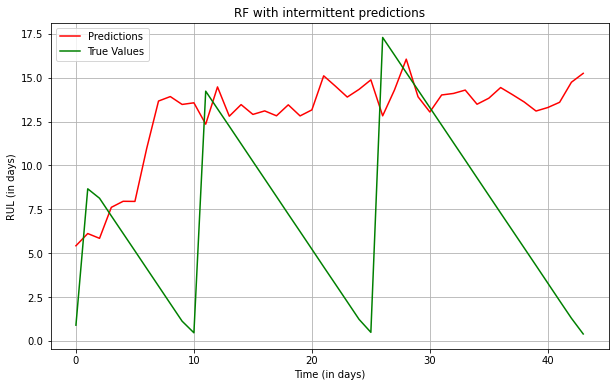

In [23]:
import matplotlib.pyplot as plt
import numpy as np

y_test_final_reset = y_test_final.reset_index(drop=True)

# Convert the arrays to pandas Series
predictions_series = pd.Series(test_predictions, name="Predictions")
true_values_series = pd.Series(y_test_final_reset, name="True values")

# Concatenate the Series into a single DataFrame
df = pd.concat([predictions_series, true_values_series], axis=1)

plt.figure(figsize=(10, 6))
plt.plot(test_predictions, label='Predictions', color='red')
plt.plot(y_test_final_reset, label='True Values', color='green')
plt.xlabel('Time (in days)')
plt.ylabel('RUL (in days)')
plt.title('RF with intermittent predictions')
plt.legend(loc='upper left')
plt.grid(True)

plt.savefig("Plot intermittent predictions.pdf")

plt.show()